In [1]:
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
df = pd.read_csv('german_credit_data.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [11]:
len(df)

1000

In [12]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [14]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [15]:
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

categorical_columns = ['Sex', 'Housing', 'Checking account', 'Purpose']
order = [['unknown', 'little', 'moderate', 'quite rich', 'rich']]

ohe = OneHotEncoder(handle_unknown='ignore')
oe = OrdinalEncoder(categories=order)

df['Saving accounts'] = oe.fit_transform(df[['Saving accounts']])

encoded_data = ohe.fit_transform(df[categorical_columns]).toarray()

encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_columns))

df = pd.concat([df, encoded_df], axis=1).drop(categorical_columns, axis=1)
df.head()

,Age,Job,Saving accounts,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_rich,Checking account_unknown,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,0.0,1169,6,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,22,2,1.0,5951,48,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,49,1,1.0,2096,12,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,45,2,1.0,7882,42,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,53,2,1.0,4870,24,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
joblib.dump(ohe, 'one_hot_encoder.joblib')
joblib.dump(oe, 'ordinal_encoder.joblib')

['ordinal_encoder.joblib']

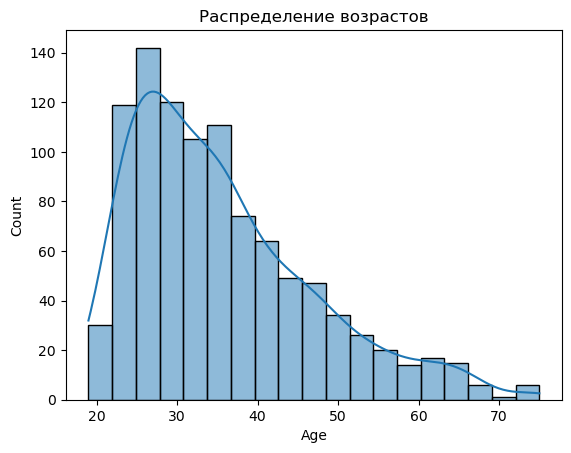

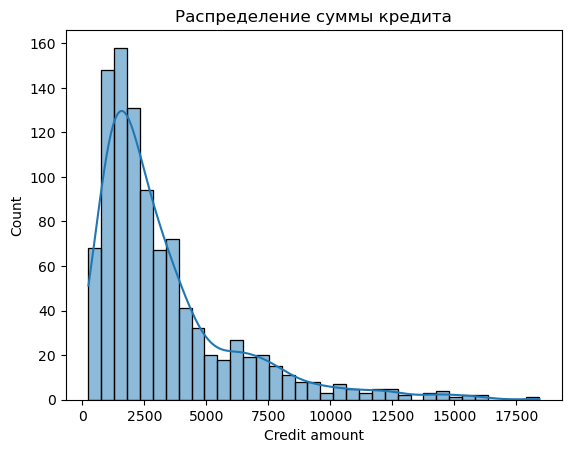

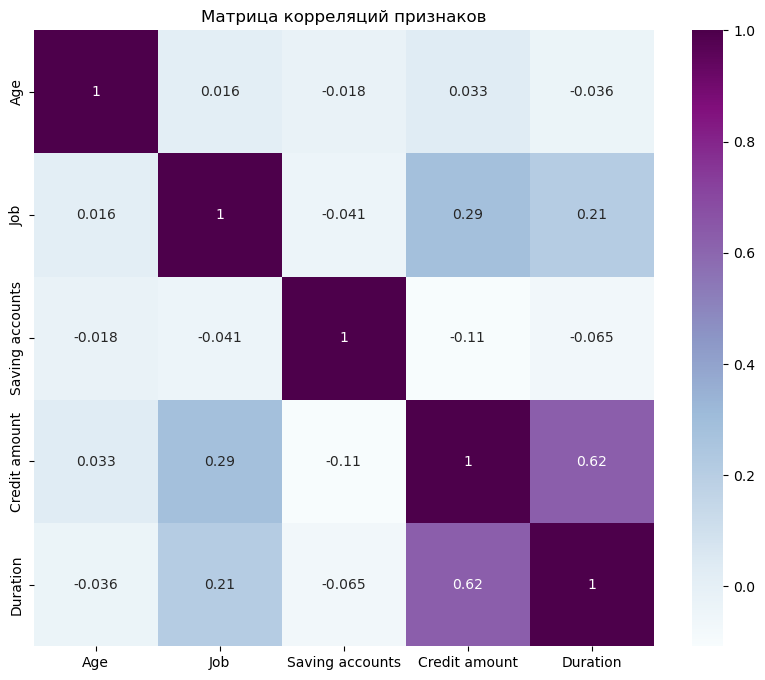

In [17]:
df = df.replace([np.inf, -np.inf], np.nan)

sns.histplot(df['Age'], kde=True)
plt.title('Распределение возрастов')
plt.show()

sns.histplot(df['Credit amount'], kde=True)
plt.title('Распределение суммы кредита')
plt.show()

df_corr = df.drop(columns = ohe.get_feature_names_out(categorical_columns))
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='BuPu')
plt.title('Матрица корреляций признаков')
plt.show()

In [19]:
X = df.drop(columns=['Credit amount'])
y = df['Credit amount'] > df['Credit amount'].median()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [21]:
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 5, 1))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring = 'roc_auc', cv = 5)
clf.fit(X_train, y_train)

best_n_estimators_value = clf.best_params_['n_estimators']
best_min_samples_leaf = clf.best_params_['min_samples_leaf']
best_max_depth = clf.best_params_['max_depth']
best_score = clf.best_score_

print('Оптимальное количество деревьев', best_n_estimators_value)
print('Оптимальное количество листьев', best_min_samples_leaf)
print('Оптимальная глубина', best_max_depth)
print('AUC-ROC', best_score)

Оптимальное количество деревьев 100
Оптимальное количество листьев 1
Оптимальная глубина 4
AUC-ROC 0.8245467675384315


In [22]:
rand_clf = RandomForestClassifier(n_estimators = best_n_estimators_value, max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf, random_state = 42)
rand_clf.fit(X_train, y_train)

y_pred = rand_clf.predict(X_test)

In [24]:
roc_auc = roc_auc_score(y_test, y_pred)
print(f'roc_auc: {roc_auc}')

roc_auc: 0.7384584504215174


In [25]:
importances = rand_clf.feature_importances_
features = pd.DataFrame({"feature": X.columns, 'importance': importances})
features.sort_values(by = 'importance', ascending = False)

,feature,importance
3,Duration,0.566469
1,Job,0.114902
0,Age,0.051535
18,Purpose_radio/TV,0.040713
2,Saving accounts,0.024929
17,Purpose_furniture/equipment,0.020553
6,Housing_free,0.019925
13,Purpose_business,0.019754
4,Sex_female,0.019628
11,Checking account_rich,0.017369


In [26]:
joblib.dump(rand_clf, 'credit_risk_random_forest_model.joblib')

['credit_risk_random_forest_model.joblib']

In [27]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print('-----------------')
print("Confusion Matrix:")
print(conf_matrix)
print('-----------------')
print("Classification Report:")
print(class_report)

Accuracy: 0.74
-----------------
Confusion Matrix:
[[81 25]
 [27 67]]
-----------------
Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.76      0.76       106
        True       0.73      0.71      0.72        94

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200



In [28]:
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 10, 3))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

clf = GridSearchCV(GradientBoostingClassifier(), grid_values, scoring = 'roc_auc', cv = 5)
clf.fit(X_train, y_train)

best_n_estimators_value_boost = clf.best_params_['n_estimators']
best_min_samples_leaf_boost = clf.best_params_['min_samples_leaf']
best_max_depth_boost = clf.best_params_['max_depth']
best_score_boost = clf.best_score_

print('Оптимальное количество деревьев', best_n_estimators_value_boost)
print('Оптимальное количество листьев', best_min_samples_leaf_boost)
print('Оптимальная глубина', best_max_depth_boost)
print('AUC-ROC', best_score_boost)

Оптимальное количество деревьев 100
Оптимальное количество листьев 6
Оптимальная глубина 1
AUC-ROC 0.8283911915176709


In [29]:
gb_clf = GradientBoostingClassifier(n_estimators=best_n_estimators_value_boost, learning_rate=0.1, min_samples_leaf = best_min_samples_leaf_boost, max_depth=best_max_depth_boost, random_state=42)

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
print(f'roc_auc: {roc_auc}')

roc_auc: 0.7649538338016861


In [31]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print('-----------------')
print("Confusion Matrix:")
print(conf_matrix)
print('-----------------')
print("Classification Report:")
print(class_report)

Accuracy: 0.77
-----------------
Confusion Matrix:
[[90 16]
 [30 64]]
-----------------
Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.85      0.80       106
        True       0.80      0.68      0.74        94

    accuracy                           0.77       200
   macro avg       0.78      0.76      0.77       200
weighted avg       0.77      0.77      0.77       200



In [32]:
joblib.dump(gb_clf, 'best_credit_risk_model.joblib')

['best_credit_risk_model.joblib']

In [33]:
df_test = df.iloc[y_test.index].copy()
df_test['Prediction'] = y_pred
df_test['Actual'] = y_test.values

true_negatives = df_test[(df_test['Actual'] == 0) & (df_test['Prediction'] == 0)]

true_positives = df_test[(df_test['Actual'] == 1) & (df_test['Prediction'] == 1)]

print("True Negatives:")
display(true_negatives)

print("\nTrue Positives:")
display(true_positives)

True Negatives:


,Age,Job,Saving accounts,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
660,23,2,1.0,1297,12,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
626,41,2,1.0,2116,6,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False
513,20,2,1.0,585,12,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
811,28,1,1.0,484,6,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
636,28,2,3.0,1376,24,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,36,2,0.0,846,7,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
526,31,2,2.0,1532,15,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,False
137,66,1,3.0,766,12,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False
365,36,2,1.0,1542,12,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False



True Positives:


,Age,Job,Saving accounts,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
740,32,2,2.0,2325,24,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
411,35,3,1.0,7253,33,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
136,27,2,4.0,8613,27,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
76,34,2,1.0,3965,42,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,True
973,36,2,1.0,7297,60,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,26,3,3.0,3235,24,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,True
332,24,3,2.0,7408,60,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
208,21,1,1.0,6568,24,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
613,22,2,1.0,3632,24,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
